In [1]:

import os
import json
import yaml
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from extract_from_configuration import get_dataset, get_device, str_to_class
import pandas as pd
import torch
from Models import *
import re
from itertools import combinations
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import art3d

In [2]:
def extend_patience_value(array, length):
    last_val = array[-1]
    reps = np.tile([last_val], length - len(array))
    return np.hstack([array, reps])

In [3]:
def extract_project_data(project_name):
    dir = os.path.join("Runs", project_name)
    data = defaultdict(dict)

    for model in os.listdir(dir):
        model_path = os.path.join(dir, model)
        runs = [x for x in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, x))]
        
        with open(os.path.join(dir, model, "config.yaml")) as f:
            config = yaml.safe_load(f)
            data[model]["config"] = config
            n = config["training"]["epochs"]
            metrics = config["output"]["metrics"]
            
        for metric in metrics:
            data[model][metric] = np.empty(shape = (len(runs), n))
            
        data[model]["model_name"] = list(range(len(runs)))
        
        for (run_id, run) in enumerate(runs):
            with open(os.path.join(model_path, run, "metrics.json"), 'r') as f:
                run_metrics = json.load(f)
                
            for metric in metrics:
                data[model][metric][run_id, :] = extend_patience_value(run_metrics[metric], n)
                
            data[model]["model_name"][run_id] = os.path.join(model_path, run, "trained_model.pt")
            
    return data

In [4]:
def get_observations(project_data, run_name):

    # Extract the dataset
    device = get_device()
    dataset_iterator = get_dataset(data_config=project_data[run_name]["config"]["data"], device=device)
    dataset = next(dataset_iterator)

    return dataset
    
def get_predictions(project_data, run_name, dataset):

    
    # Get the trained model
    device = get_device()
    model_name = project_data[run_name]["model_name"][0]
    model = torch.load(model_name, weights_only=False)
    model.eval();
    model.to(device)

    # Extract the predictions
    with torch.no_grad():
        predictions = list([model(x[0].unsqueeze(0)).detach()[0] for x in dataset])

    return predictions

def postprocess_gaussian_predictions(project_data, run_name, predictions):
    
    # Data characteristics
    data_parameters = project_data[run_name]["config"]["data"]["parameters"]
    w = data_parameters["w"]
    d = data_parameters["d"]

    # Probabilistic model
    prob_model = str_to_class(project_data[run_name]["config"]["model"]["prob_model"])(d, w)

    # Extract mean vectors and covariance matrices
    params = list(prob_model.array2parameters(pred) for pred in predictions)
    mu_list = list(param["mean"] for param in params)
    cov_list = list(prob_model.cov_matrix(param) for param in params)
    # cov_list = list(prob_model.invert_cholesky(L) for L in L_list)

    # Put data in correct format
    cov_arr = np.array(list(cov.reshape(w * d, w * d).detach().cpu().numpy() for cov in cov_list))
    mu_arr = np.array(list(mu.reshape(w, d).detach().cpu().numpy() for mu in mu_list))
    
    return mu_arr, cov_arr

def postprocess_observations(dataset):
    
    data_x = np.array([np.array(x[0].cpu()) for x in dataset])
    data_y = np.array([np.array(x[1].cpu()) for x in dataset])

    return data_x, data_y

def get_covariance(cov, w1, d1, w2, d2, w):
    id1 = w1 + d1 * w
    id2 = w2 + d2 * w
    return cov[id1, id2]
    

def get_run_df(project_data, run_name):

    # Extract required values
    dataset = get_observations(project_data=project_data, run_name=run_name)
    predictions = get_predictions(project_data=project_data, run_name=run_name, dataset=dataset)

    # Postprocess values
    data_x, data_y = postprocess_observations(dataset)
    T, w, prev_days, d = data_x.shape
    mu_arr, cov_arr = postprocess_gaussian_predictions(project_data, run_name, predictions)
    std_arr = np.array(list(np.sqrt(np.diag(cov)).reshape(w, d) for cov in cov_arr))
    
    data_x = np.swapaxes(data_x[:, :, 0, :], 1, 2)
    data_y = np.swapaxes(data_y, 1, 2)
    mu_arr = np.swapaxes(mu_arr, 1, 2)
    std_arr = np.swapaxes(std_arr, 1, 2)

    
    # Format for use in DataFrame
    out_arr = np.column_stack([
        np.repeat(np.arange(1, T + 1, dtype = int), d),
        np.tile(np.arange(1, d + 1, dtype = int), T),
        data_x.reshape(T * d, -1),
        data_y.reshape(T * d, -1),
        mu_arr.reshape(T * d, -1),
        std_arr.reshape(T * d, -1),
    ])

    out_df = pd.DataFrame(out_arr, columns = [
        "Days", 
        "Coordinate", 
        *["Var " + str(i) + " (prev)" for i in np.arange(1, w + 1, dtype = int)],
        *["Var " + str(i) for i in np.arange(1, w + 1, dtype = int)],
        *["Var " + str(i) + " (mean)" for i in np.arange(1, w + 1, dtype = int)],
        *["Var " + str(i) + " (std)" for i in np.arange(1, w + 1, dtype = int)]
        ])
    out_df["Days"] = out_df["Days"].astype(int)
    out_df["Coordinate"] = out_df["Coordinate"].astype(int)
    
    return out_df, cov_arr

def get_mean(df, day, w1, d1):
    return df[(df["Days"] == day) & (df["Coordinate"] == d1)][f"Var {w1} (mean)"].iloc[0]

In [19]:
project_name = "TrainingEval"
project_data = extract_project_data(project_name)

run_df = dict()

for run_name in project_data.keys():
    df, cov_arr = get_run_df(project_data=project_data, run_name=run_name)
    run_df[run_name] = dict()
    run_df[run_name]["df"] = df
    run_df[run_name]["cov_arr"] = cov_arr

In [6]:
def get_obs(w1, d1, w2, d2, df):

    x = []
    y = []
    
    days = range(df["Days"].max())
    for day in days:
        df_filtered = df[df["Days"] == day + 1]

        df1 = df_filtered[df_filtered["Coordinate"] == d1 + 1]
        df2 = df_filtered[df_filtered["Coordinate"] == d2 + 1]

        x.append(df1[f"Var {w1 + 1}"].iloc[0])
        y.append(df2[f"Var {w2 + 1}"].iloc[0])

    return x,y

def get_mean_and_cov_lists(w1, d1, w2, d2, df, cov_arr):
    mu_list = []
    sigma_list = []

    for day in range(cov_arr.shape[0]):
        cov = cov_arr[day]
        w = sum(re.search("^Var \d$", col) is not None for col in df.columns)
        s_xx = get_covariance(cov, w1, d1, w1, d1, w)
        s_xy = get_covariance(cov, w1, d1, w2, d2, w)
        s_yy = get_covariance(cov, w2, d2, w2, d2, w)

        mu_x = get_mean(df, day + 1, w1 + 1, d1 + 1)
        mu_y = get_mean(df, day + 1, w2 + 1, d2 + 1)

        mu = np.array([mu_x, mu_y])
        Sigma = np.array([[s_xx, s_xy], [s_xy, s_yy]])

        mu_list.append(mu)
        sigma_list.append(Sigma)

    return np.array(mu_list), np.array(sigma_list)

In [7]:
def plot_2d_gaussian_contour(mean, covariance, levels=10, grid_size=100, ax=None):
    """
    Plots a contour for a 2D Gaussian distribution.

    Parameters:
        mean (array-like): The mean of the Gaussian [mu_x, mu_y].
        covariance (array-like): The 2x2 covariance matrix of the Gaussian.
        levels (int): Number of contour levels to display (default: 10).
        grid_size (int): Resolution of the grid for plotting (default: 100).
        ax (matplotlib.axes._axes.Axes, optional): Existing matplotlib Axes to plot on.
    """
    # Create a grid of x and y values
    x = np.linspace(mean[0] - 3 * np.sqrt(covariance[0, 0]), mean[0] + 3 * np.sqrt(covariance[0, 0]), grid_size)
    y = np.linspace(mean[1] - 3 * np.sqrt(covariance[1, 1]), mean[1] + 3 * np.sqrt(covariance[1, 1]), grid_size)
    X, Y = np.meshgrid(x, y)

    # Create a multivariate normal distribution
    rv = multivariate_normal(mean, covariance)

    # Evaluate the probability density function on the grid
    Z = rv.pdf(np.dstack((X, Y)))

    # Plot the contour
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    contour = ax.contour(X, Y, Z, levels=levels, cmap='viridis')
    ax.set_title('2D Gaussian Contour Plot')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.axis('equal')
    ax.grid(True)
    plt.colorbar(contour, ax=ax, label='PDF Value')
    plt.show()

In [8]:
def plot_3d_gaussian_evolution(means, covariances, grid_size=100, time_steps=None, n_std=1):
    """
    Plots a 3D visualization of the evolution of 2D Gaussian contours over time.

    Parameters:
        means (list): List of mean vectors [mu_x, mu_y] for each time step.
        covariances (list): List of 2x2 covariance matrices for each time step.
        grid_size (int): Resolution of the grid for plotting (default: 100).
        time_steps (list, optional): List of time step values. Defaults to range(len(means)).
    """
    # Validate inputs
    if len(means) != len(covariances):
        raise ValueError("Means and covariances must have the same length.")
    
    if time_steps is None:
        time_steps = range(len(means))
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for t in time_steps:
        mean = means[t]
        covariance = covariances[t]
        
        # # Create a grid of x and y values
        # x = np.linspace(mean[0] - 3 * np.sqrt(covariance[0, 0]), mean[0] + 3 * np.sqrt(covariance[0, 0]), grid_size)
        # y = np.linspace(mean[1] - 3 * np.sqrt(covariance[1, 1]), mean[1] + 3 * np.sqrt(covariance[1, 1]), grid_size)
        # X, Y = np.meshgrid(x, y)
        
        # # Create a multivariate normal distribution
        # rv = multivariate_normal(mean, covariance)
        
        # # Evaluate the probability density function on the grid
        # Z = rv.pdf(np.dstack((X, Y)))
        
        # # Normalize Z for better visualization
        # Z /= Z.max()
        
        # # Add the contour at the current time step
        # ax.contour3D(X, Y, Z, cmap='viridis', offset = t, zdir = 'z', alpha=0.7)
        
        # With elipses
                # Calculate the eigenvalues and eigenvectors for the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)
        order = eigenvalues.argsort()[::-1]  # Sort eigenvalues descending
        eigenvalues = eigenvalues[order]
        eigenvectors = eigenvectors[:, order]

        # Get the angle of the ellipse
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Width and height of the ellipse (2 * n_std * sqrt(eigenvalue))
        width, height = 2 * n_std * np.sqrt(eigenvalues)

        # Add the ellipse to the plot
        ellipse = Ellipse(
            xy=mean, width=width, height=height, angle=angle, alpha=0.5, color='blue'
        )
        ax.add_patch(ellipse)
        ax.plot([mean[0]], [mean[1]], [t], 'ro')  # Plot the mean point at this time
        art3d.pathpatch_2d_to_3d(ellipse, z=t, zdir="z")


    # Extract the mean points for connecting ellipses
    mean_x = [means[t][0] for t in time_steps]
    mean_y = [means[t][1] for t in time_steps]
    mean_t = list(time_steps)

    # Plot the connecting lines between the ellipses
    ax.plot(mean_x, mean_y, mean_t, color='black', linestyle='--', linewidth=3, label='Mean trajectory')


    ax.set_title('3D Evolution of 2D Gaussian Contours Over Time')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Time / PDF Level')
    
    ax.set_zlim(min(time_steps), max(time_steps))
    ax.legend()
    
    return fig, ax

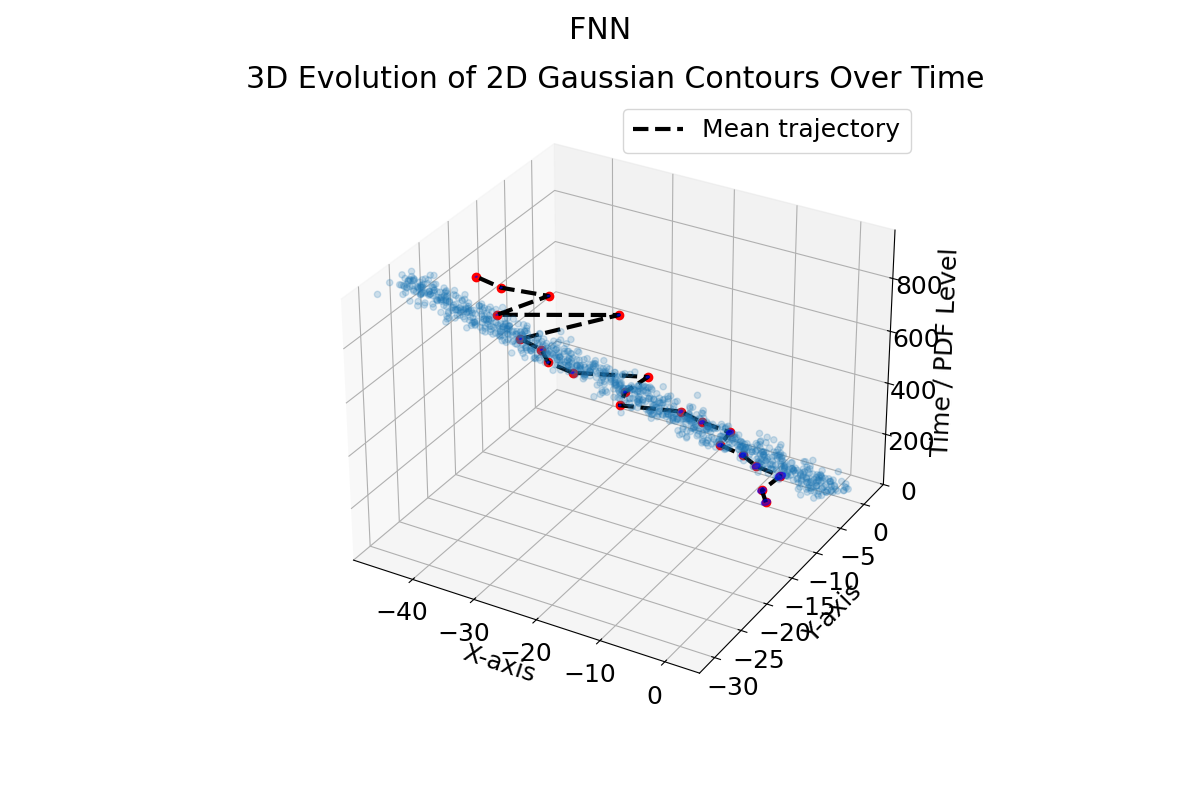

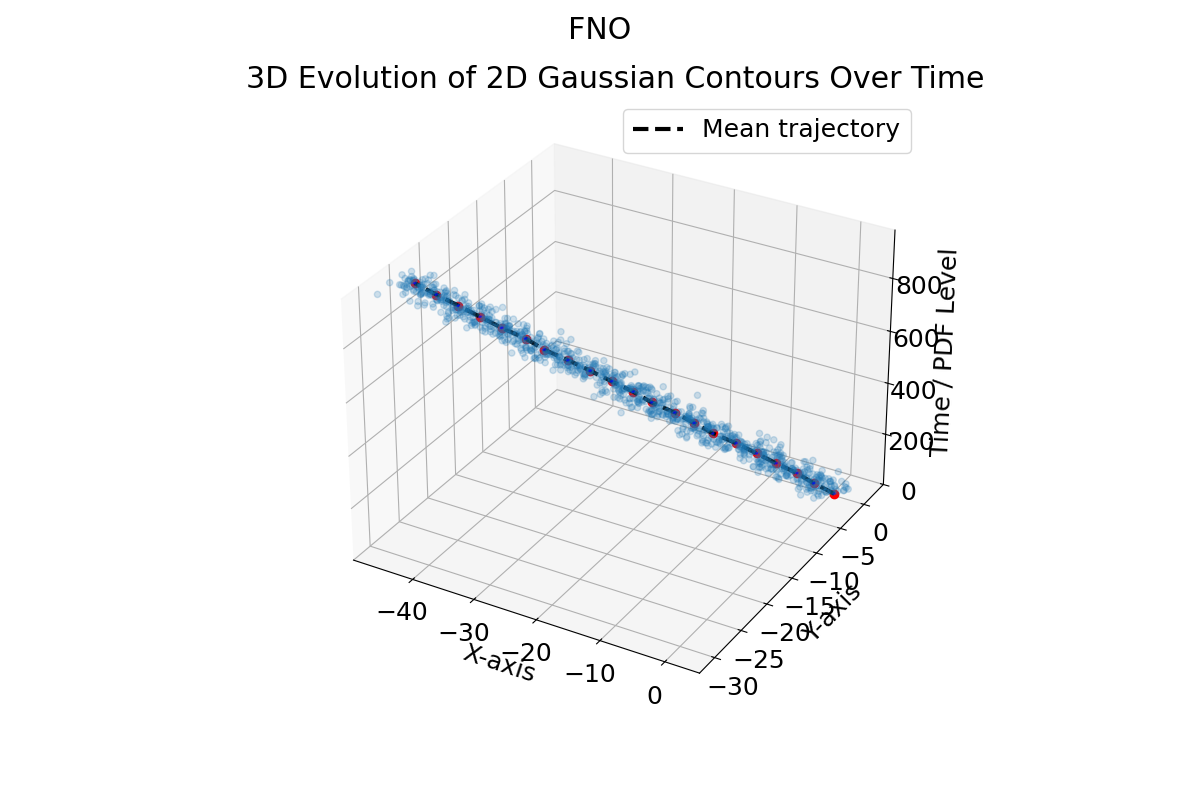

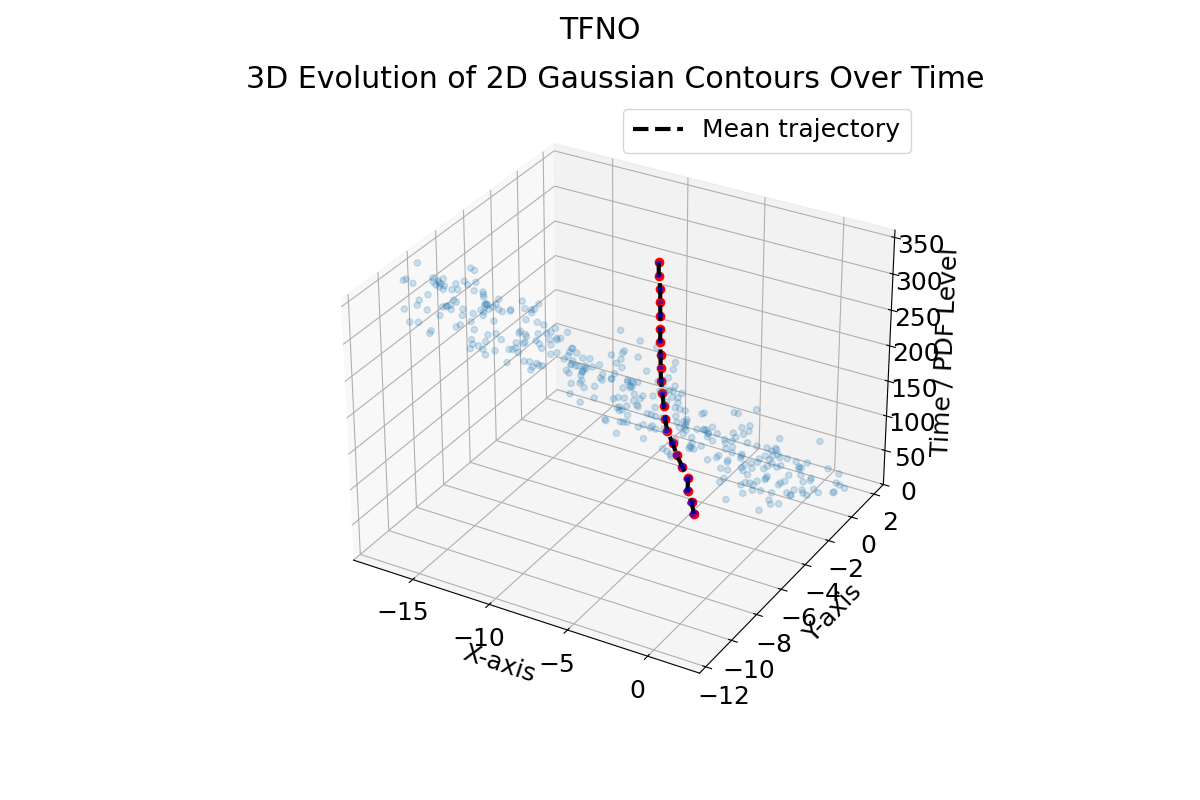

In [20]:
%matplotlib widget

d1 = 0
d2 = 3
w1 = 2
w2 = 4

for run_name, df_dict in run_df.items():
    df = df_dict["df"]
    cov_arr = df_dict["cov_arr"]
    means, covariances = get_mean_and_cov_lists(w1, d1, w2, d2, df, cov_arr)
    n_time_steps = 20
    time_steps = np.arange(0, len(means), len(means) // n_time_steps)
    fig, ax = plot_3d_gaussian_evolution(means, covariances, time_steps=time_steps)
    fig.suptitle(run_name)

    x_obs, y_obs = get_obs(w1, d1, w2, d2, df)
    z_vals = list(range(df["Days"].max()))
    ax.scatter(x_obs, y_obs, z_vals, alpha = 0.2, label="Data")

In [11]:
def plot_observations_vs_predictions(df):
    fig_scale = 4
    d = df["Coordinate"].unique().shape[0]
    w = sum(re.search("^Var \d$", col) is not None for col in df.columns)
    fig, axes = plt.subplots(d,w,figsize=(w * fig_scale, d * fig_scale))

    font = {'size'   : 18}
    plt.rc('font', **font)

    for i, ax in enumerate(np.ravel(axes)):
        dd = i // w
        ww = i % w
        var_name = f"Var {ww + 1}"
        coord = dd + 1
        
        

        plot_df = df[df["Coordinate"] == coord]
        ax.scatter(x = plot_df["Days"], y = plot_df[var_name], label = "Data")
        ax.plot( plot_df["Days"], plot_df[var_name + " (mean)"], label=f"Prediction (mean)", linewidth=2, c = 'darkorange')
        ax.fill_between(x = plot_df["Days"], 
                        y1 = plot_df[var_name + " (mean)"] - plot_df[var_name + " (std)"], 
                        y2 = plot_df[var_name + " (mean)"] + plot_df[var_name + " (std)"], 
                        alpha=0.7, label=f"Prediction (std)")

        if ww == 0:
            ax.set_ylabel("Value")

        if dd == d - 1:
            ax.set_xlabel("Day")
        # ax.errorbar(, yerr = plot_df["Var 1 (std)"], label = "Prediction", c = "red")
        # ax.legend()
        # break

    handles, labels = ax.get_legend_handles_labels()
    fig.suptitle("Observations versus predictions\n\n\n\n")
    fig.legend(handles, labels, ncol = 5, loc = 'upper center', bbox_to_anchor = (0.5, 0.97))
    fig.tight_layout()
    return fig

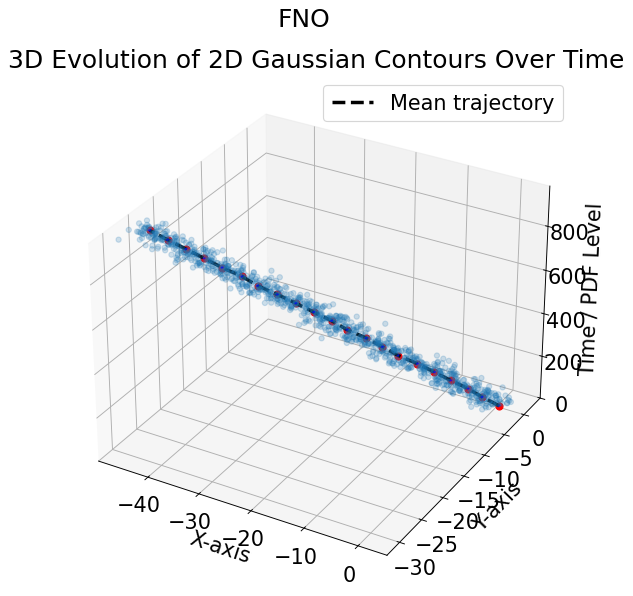

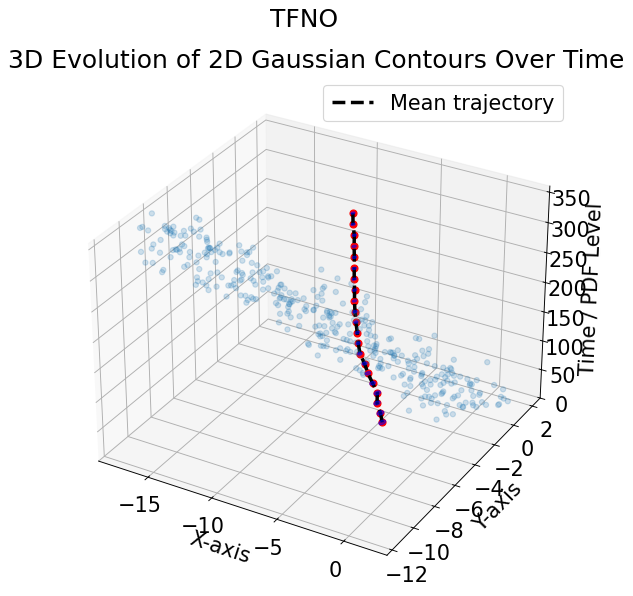

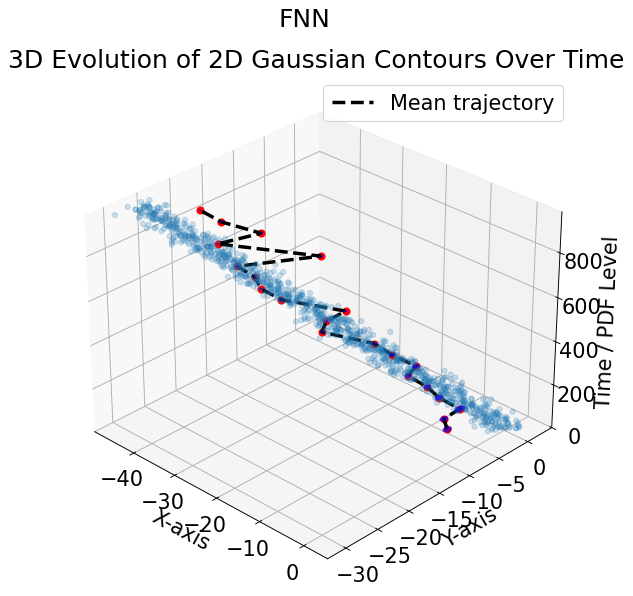

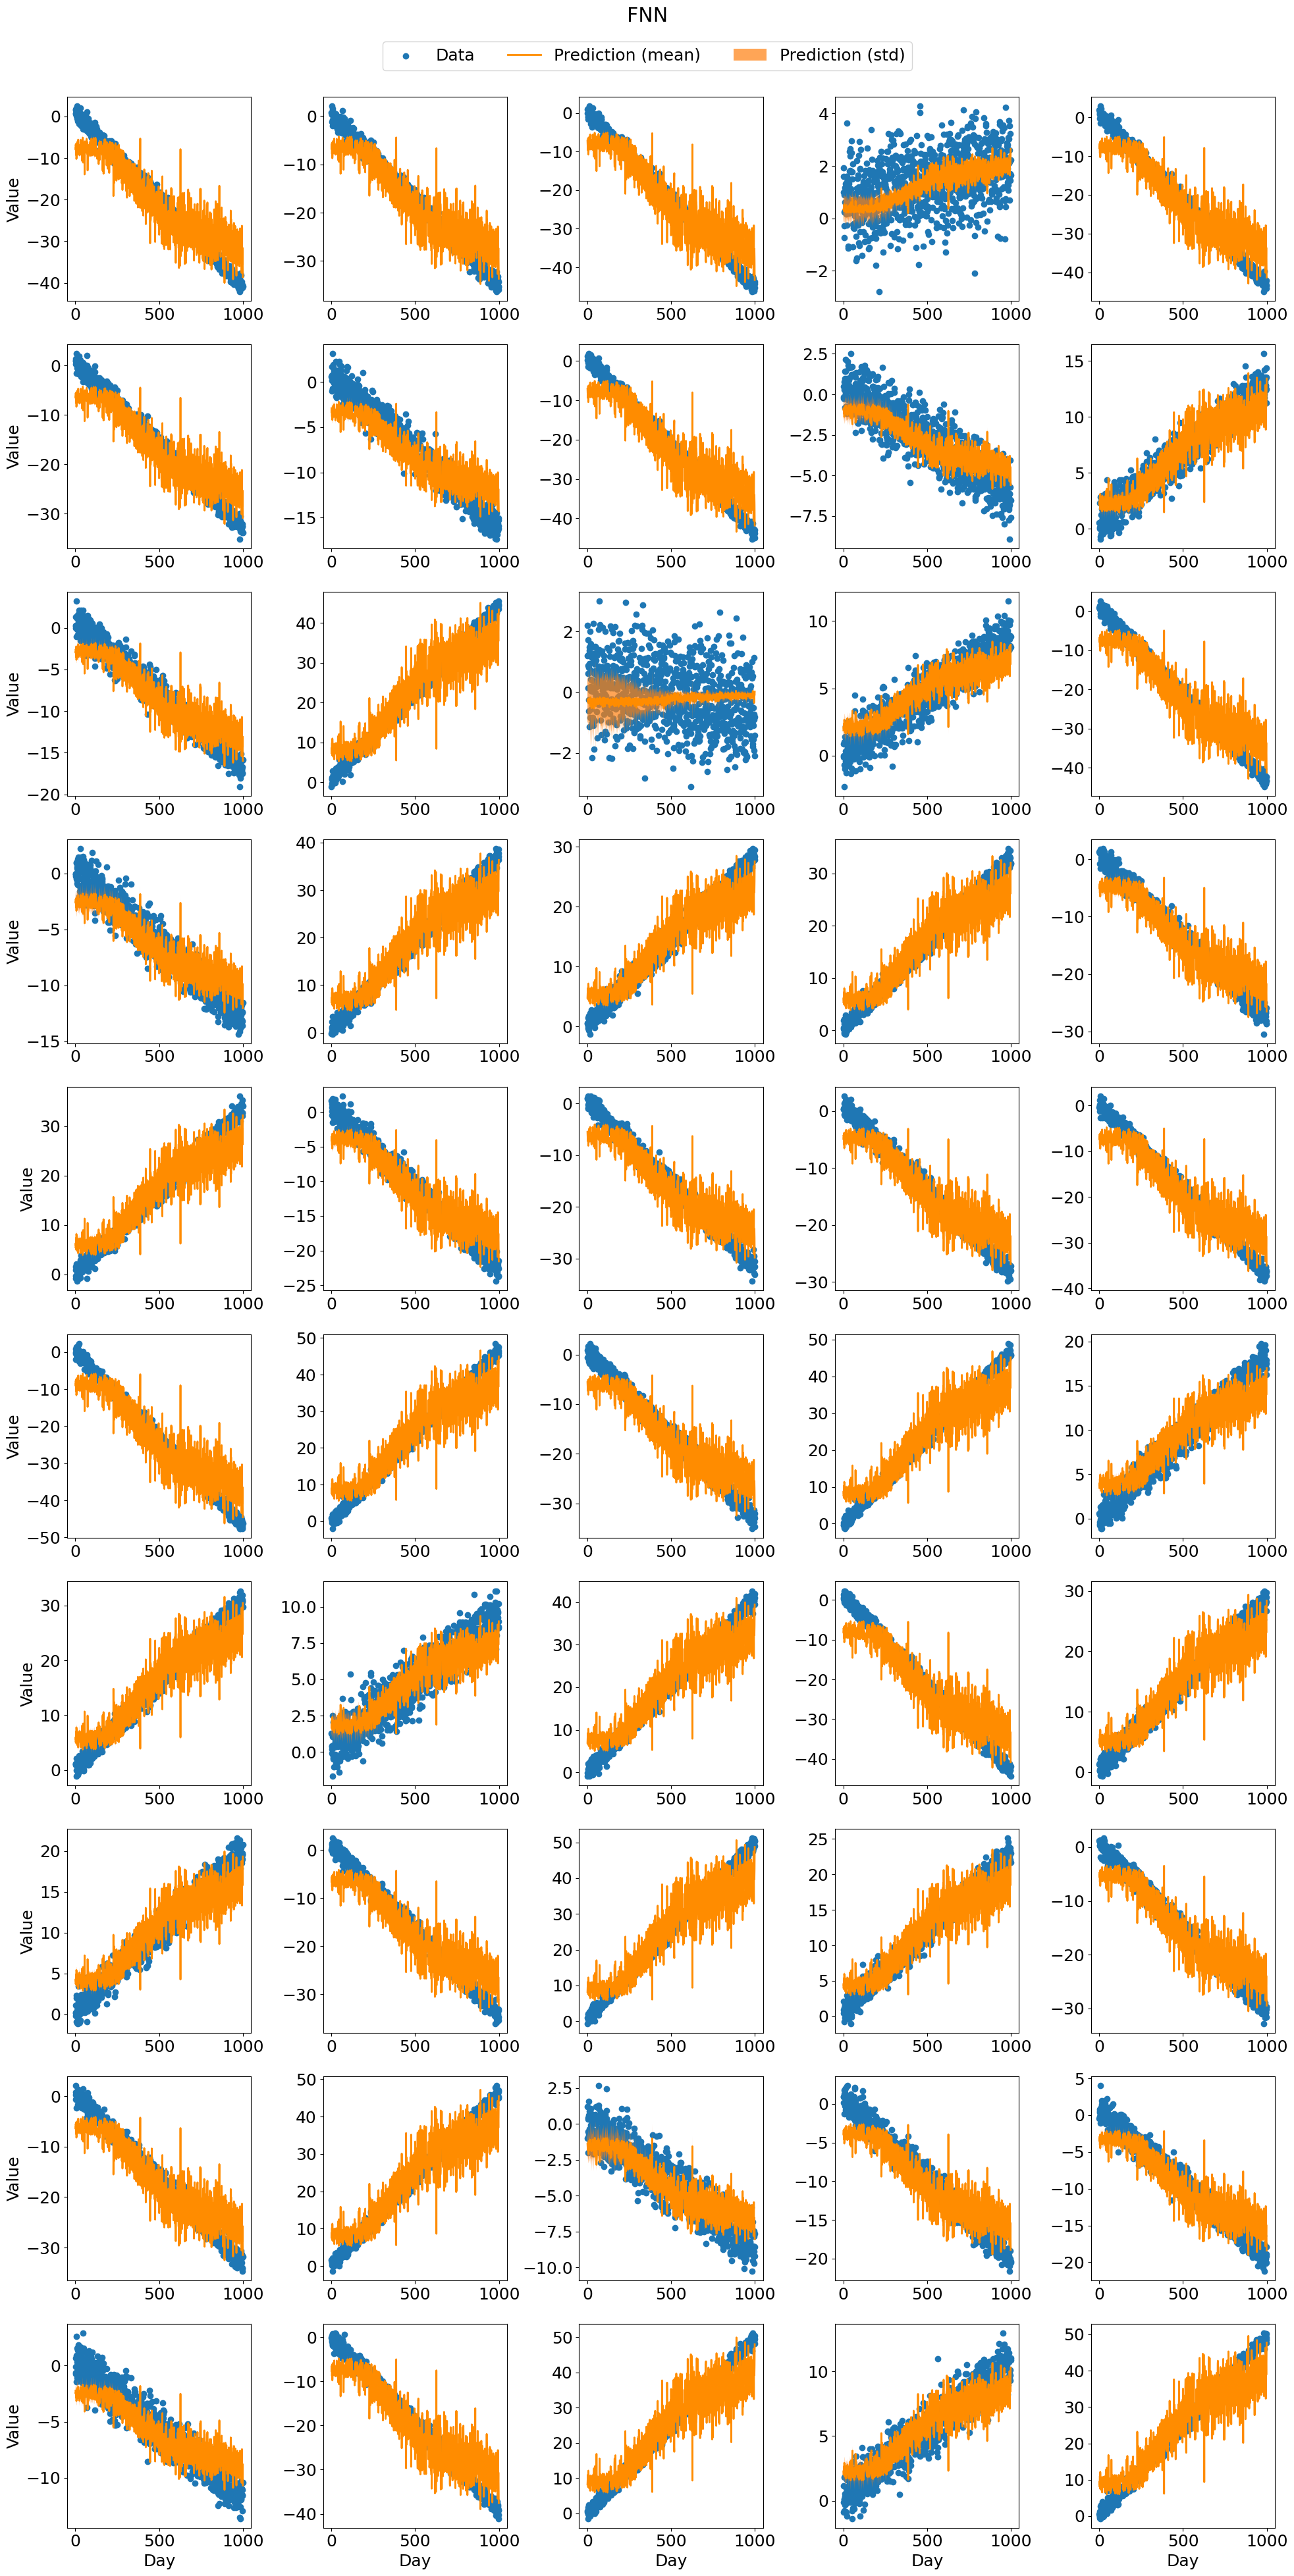

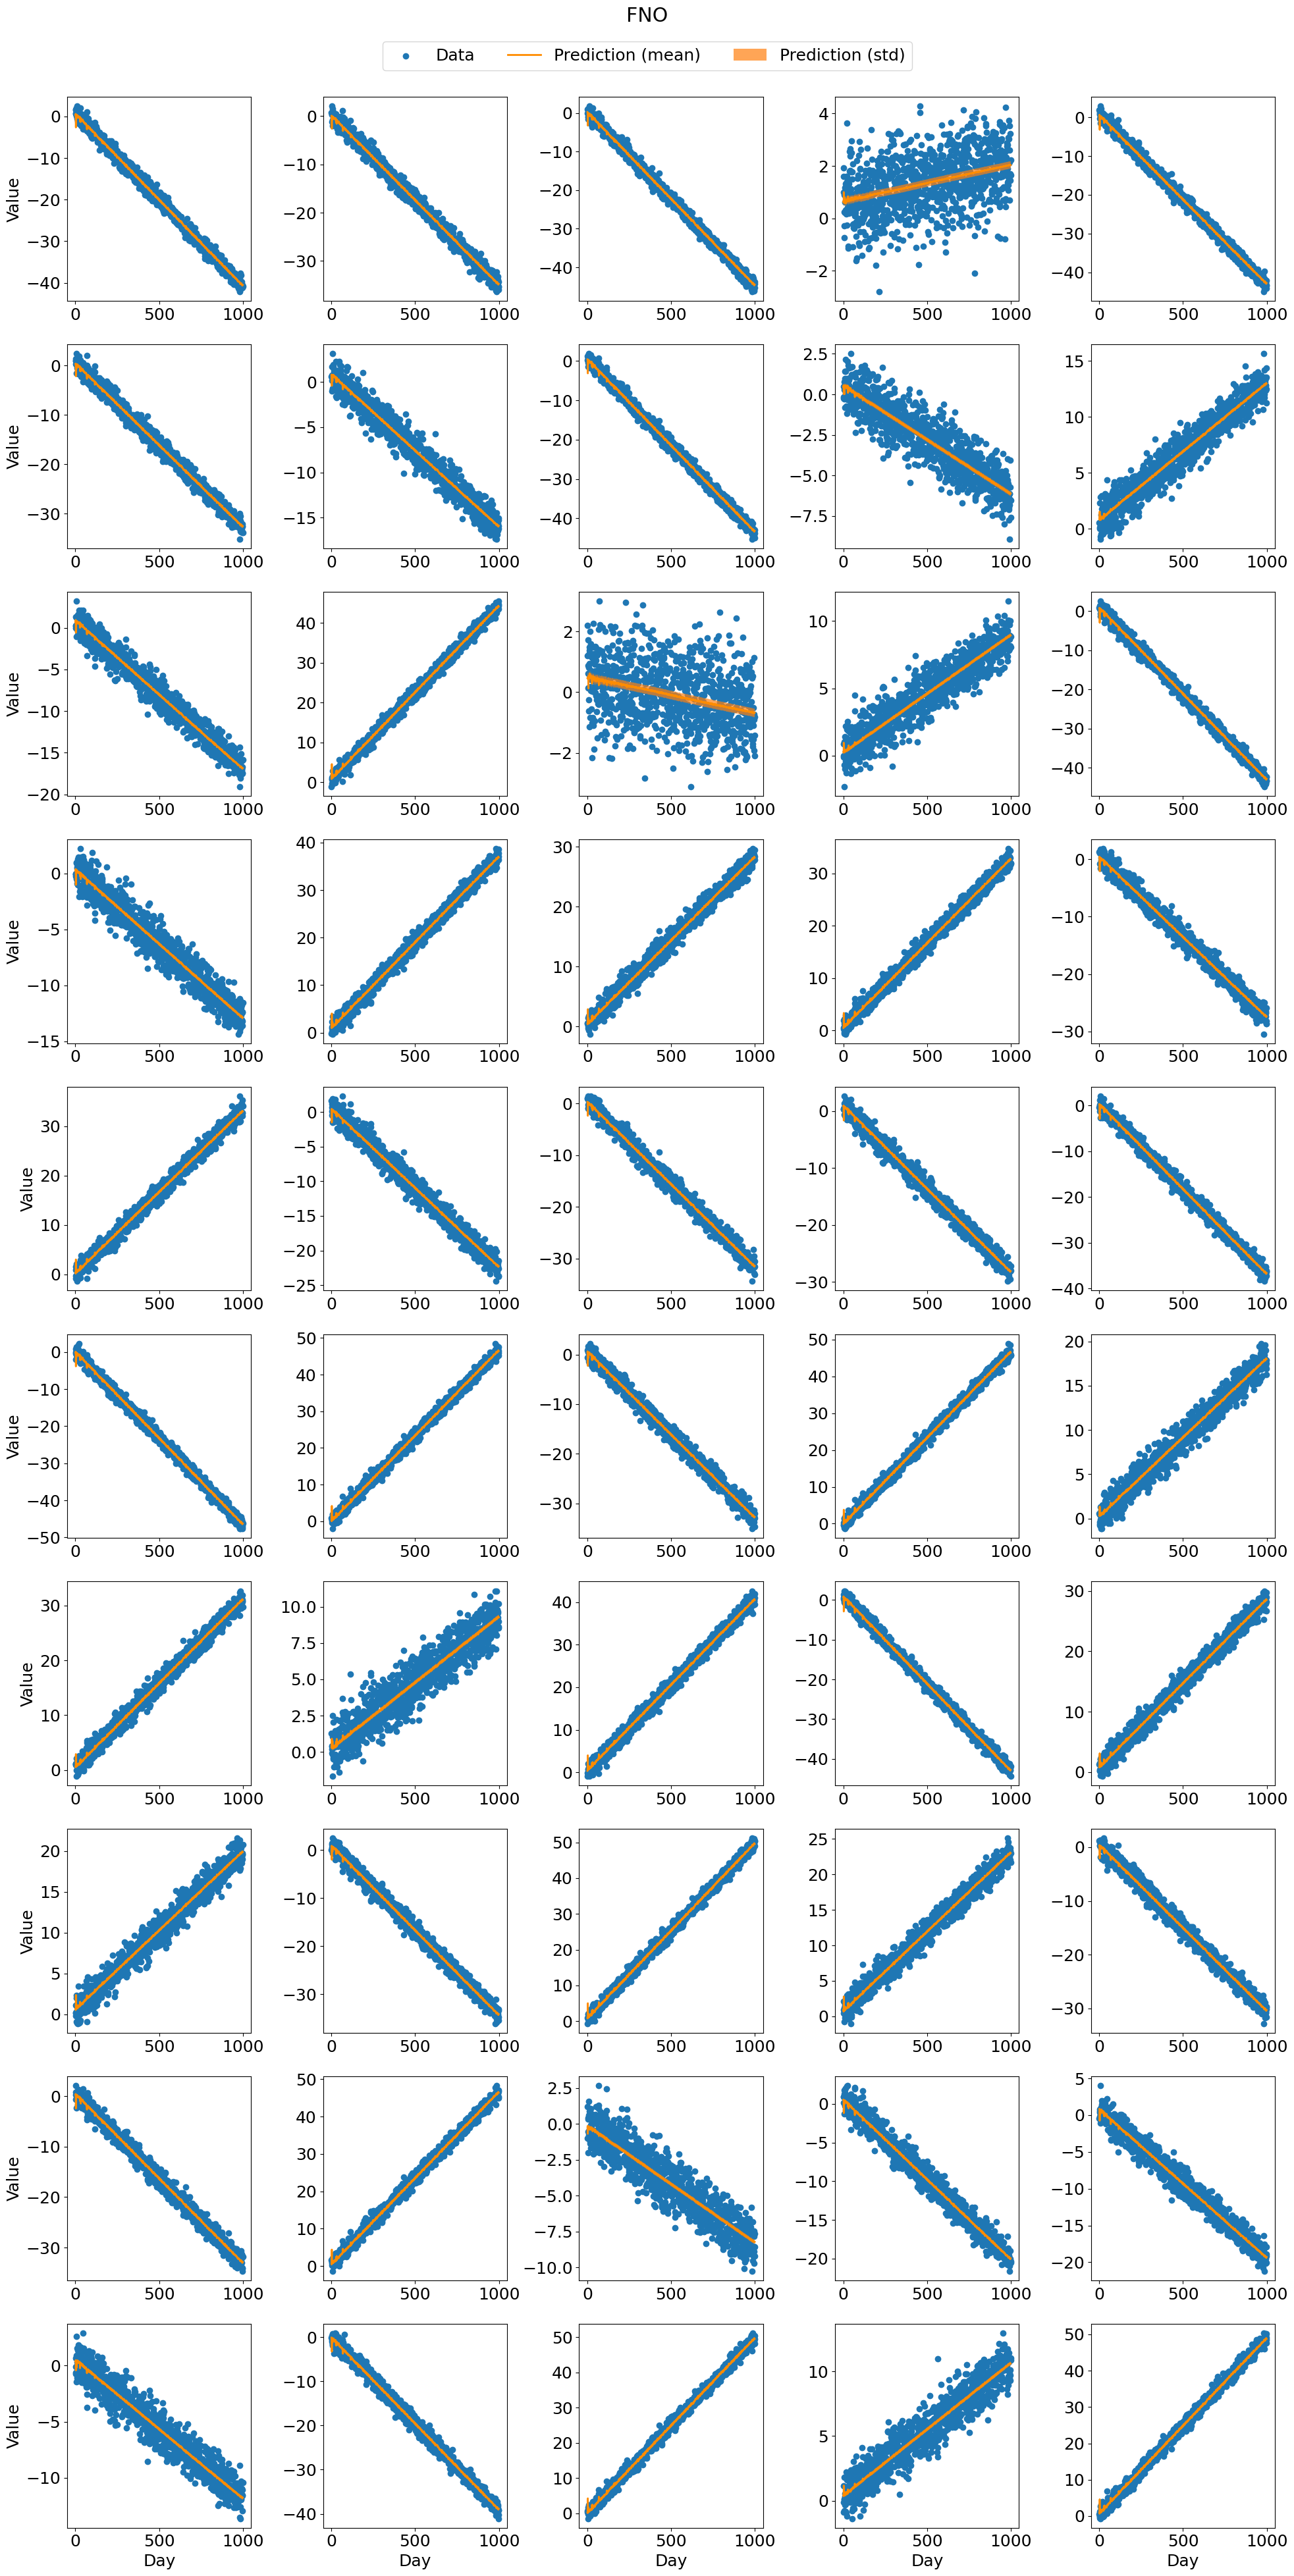

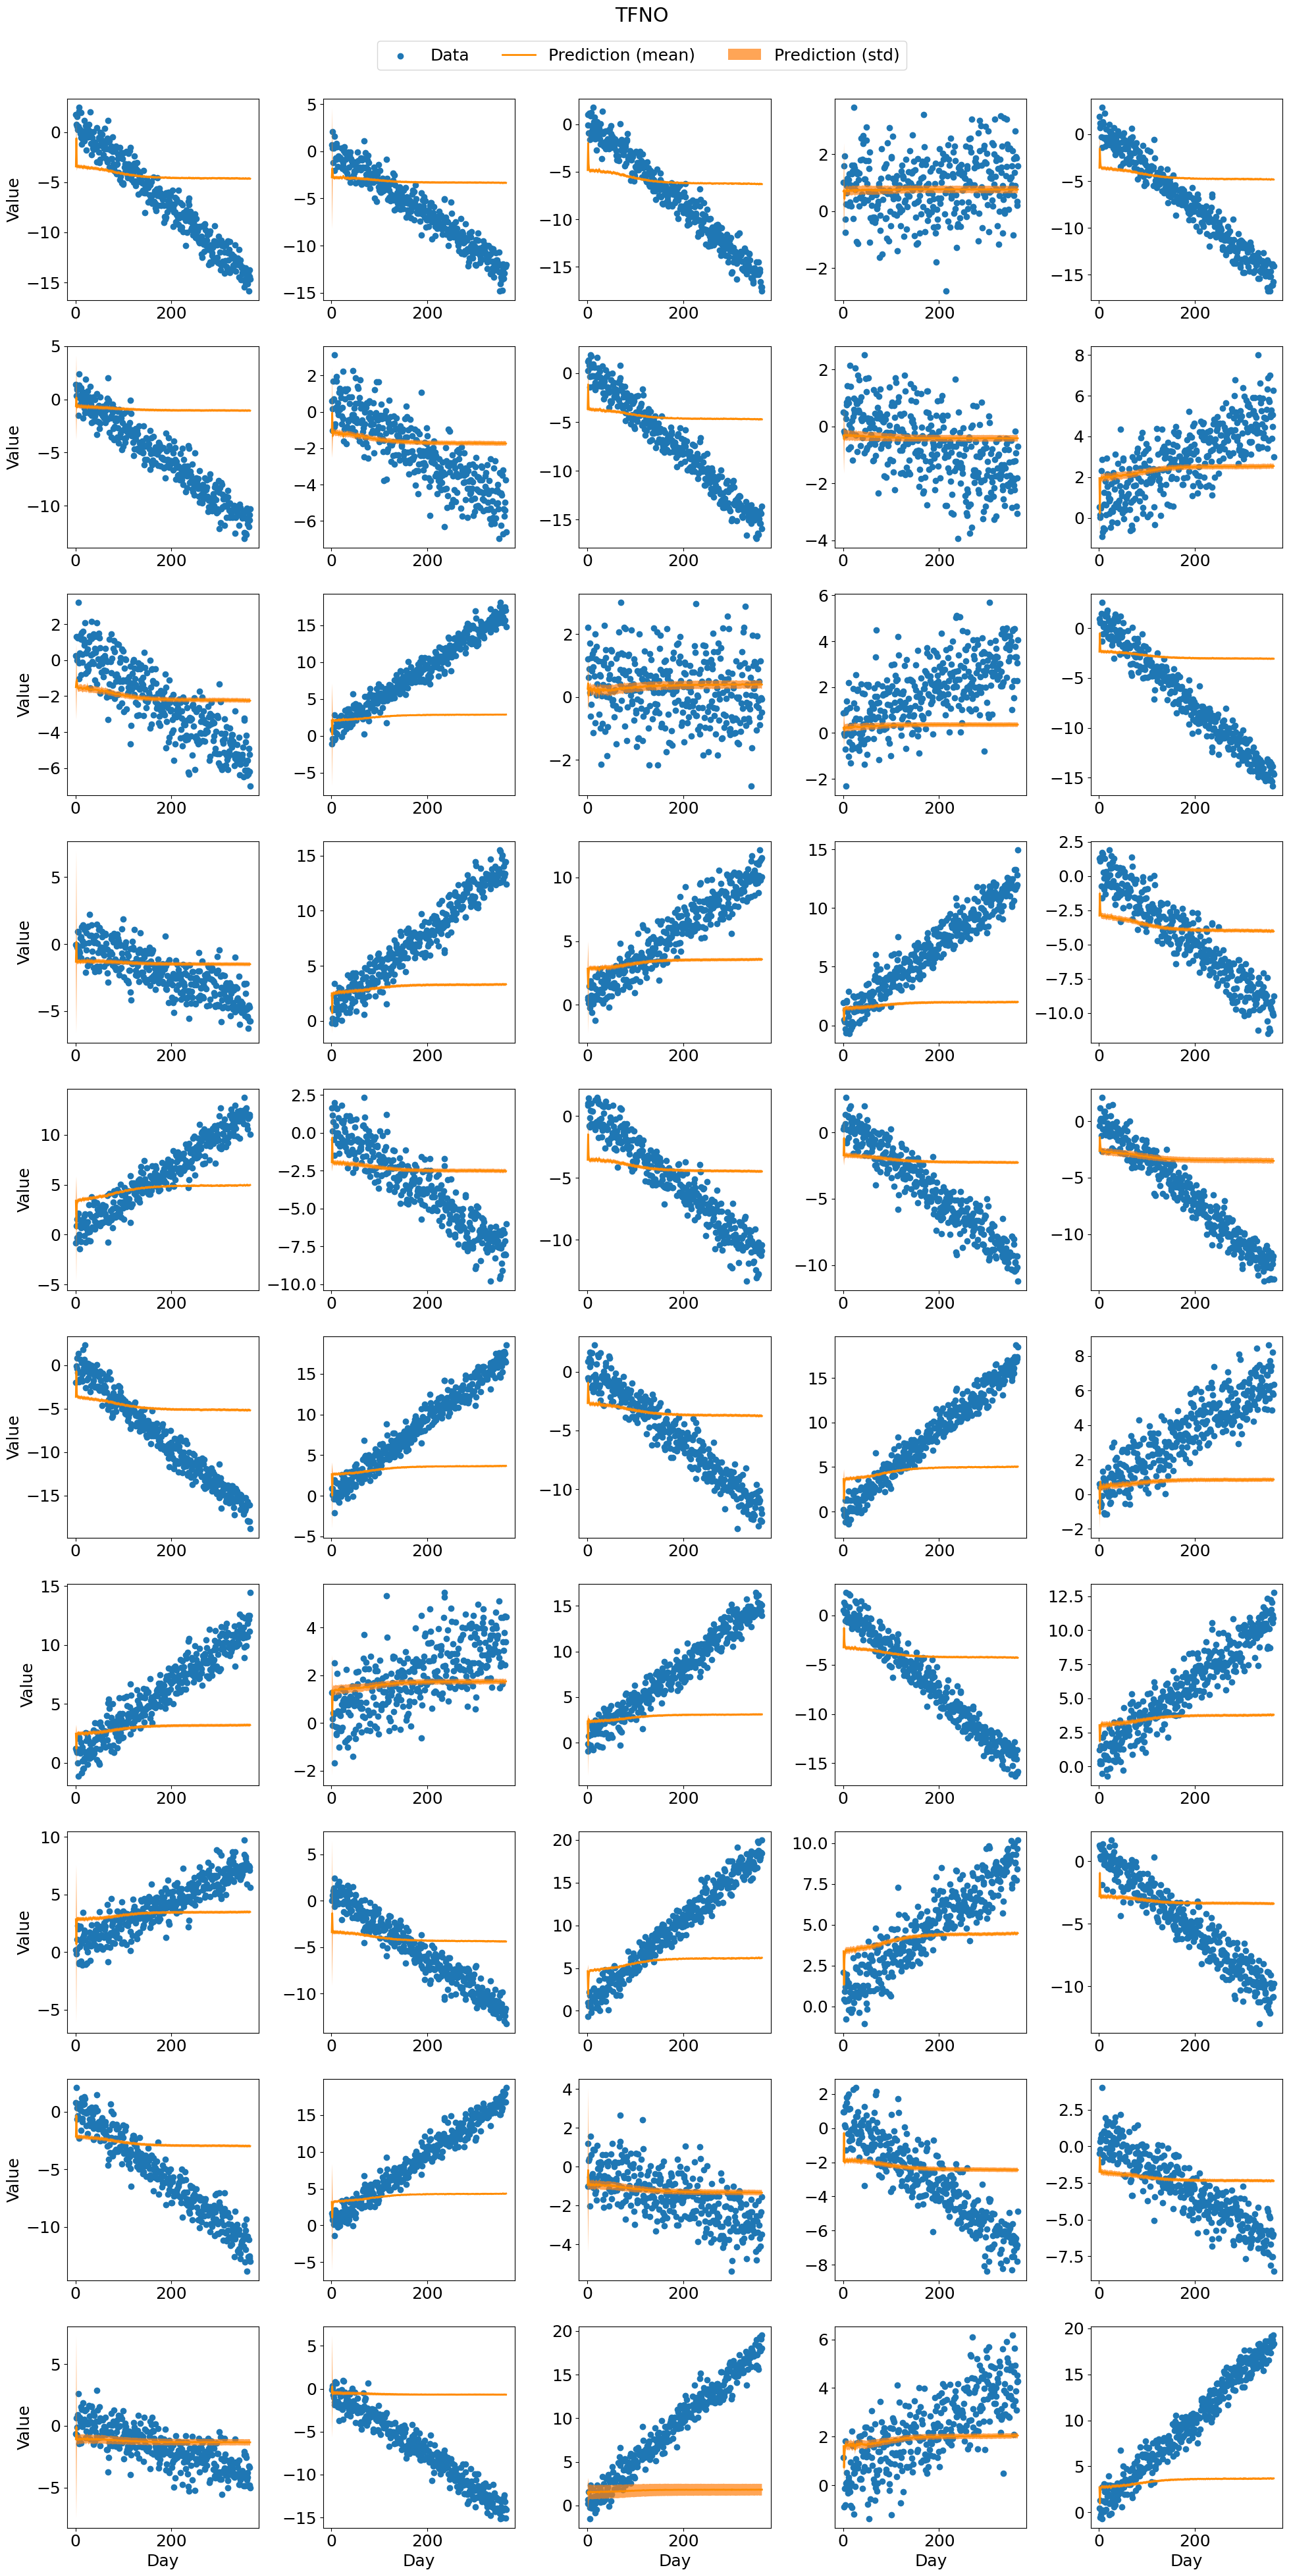

In [21]:
%matplotlib inline

for run_name, df_dict in run_df.items():
    df = df_dict["df"]
    fig = plot_observations_vs_predictions(df);
    fig.suptitle(run_name)

In [13]:
def plot_metric(data, metric='train_loss', value = "mean", scale = "linear"):
    """
    Plot metric for multiple models, runs, and epochs.
    
    Parameters:
        data (dict): A dictionary where data[model][metric] is an n x m numpy array 
                     (n = number of runs, m = number of epochs).
        metric (str): The metric to plot (e.g., 'training_loss').
    """
    plt.figure(figsize=(12, 8))
    
    for model, metrics in data.items():
        if metric not in metrics:
            print(f"Metric '{metric}' not found for model '{model}'. Skipping...")
            continue
        
        # Extract the metric array (n x m)
        values = metrics[metric]
        min_values = values.min(axis=0)  # Mean across runs
        mean_values = values.mean(axis=0)  # Mean across runs
        std_values = values.std(axis=0)   # Standard deviation across runs
        epochs = np.arange(1, values.shape[1] + 1)  # Epoch indices

        if value == "mean":
            # Plot mean with shaded region for standard deviation
            plt.plot(epochs, mean_values, label=f"{model} (mean)", linewidth=2)
            plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, 
                            alpha=0.2, label=f"{model} (std dev)")
        elif value == "min":
            plt.plot(epochs, min_values, label=f"{model} (min)", linewidth=2)
        else:
            raise NotImplementedError(f"Value ({value}) not implemented.")
    
    # Customize plot
    plt.title(f"{metric.replace('_', ' ').capitalize()} Across Models", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    nticks = 10
    plt.xticks(epochs[::len(epochs)//nticks])
    plt.ylabel(metric.replace('_', ' ').capitalize(), fontsize=14)
    plt.yscale(scale)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

c:\Users\mgjfl\miniconda3\envs\nop\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


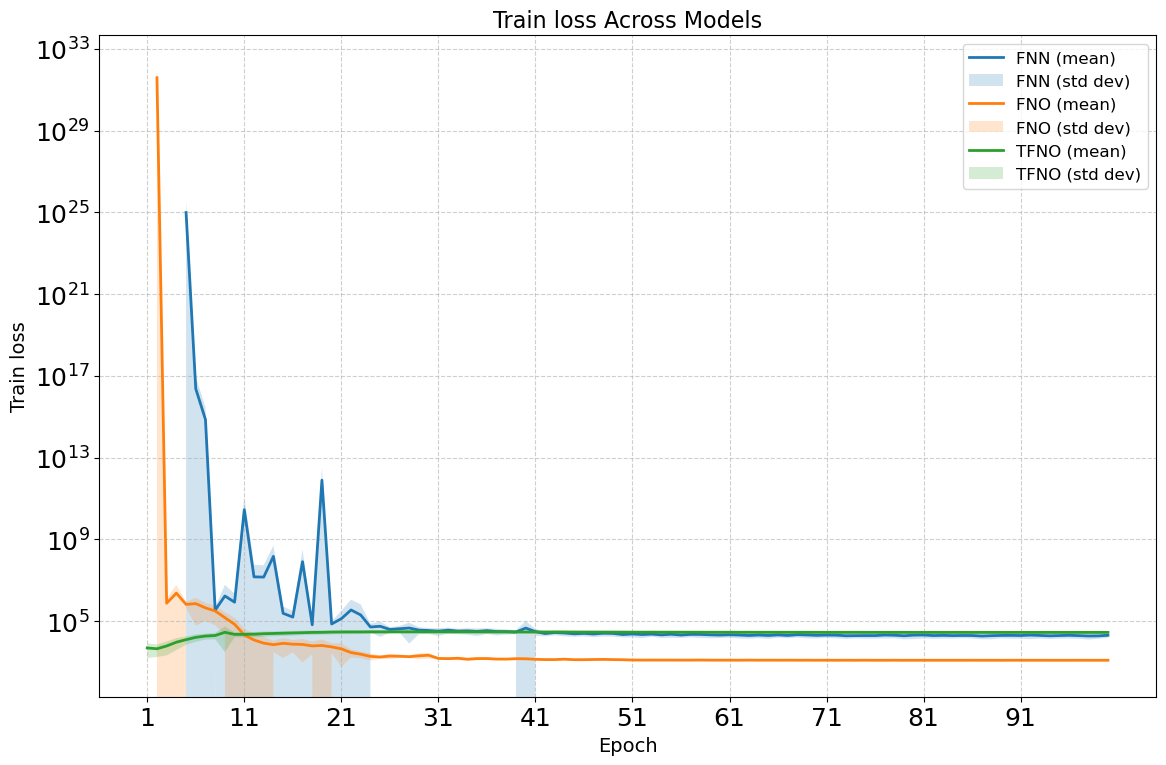

In [14]:
plot_metric(project_data, scale = "log")

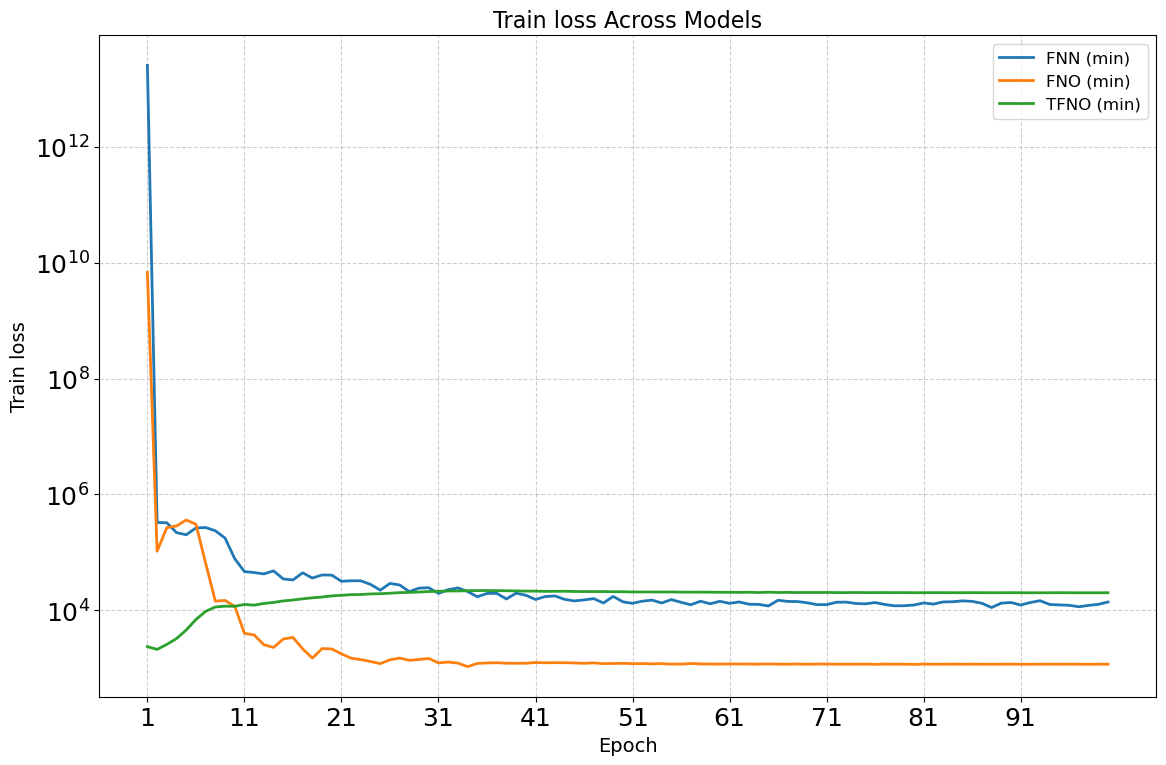

In [15]:
plot_metric(project_data, value = "min", scale = "log")